# IT1244 Project

## Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [119]:
import re as re
import heapq as heapq
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import random as random
from sklearn.preprocessing import StandardScaler
import pyarrow as pa
import pyarrow.parquet as pq
from sklearn.decomposition import PCA
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from collections import Counter

### Import Bert Encoders

In [3]:
import torch as torch
from transformers import BertModel
from transformers import BertTokenizer, BertTokenizerFast

### Testing Bert Encoding

In [78]:

# Load tokenizer and model
#model = BertModel.from_pretrained('bert-base-uncased')
#tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-base', use_fast=True)
model = AutoModel.from_pretrained('vinai/bertweet-base')
# Encode sentences
sentence1 = "This is an example sentence with change negative."
inputs1 = tokenizer(sentence1, return_tensors="pt")

sentence2 = "This is an example sentence with change upset."
inputs2 = tokenizer(sentence2, return_tensors="pt")

sentence3 = "This is an example sentence with change happy."
inputs3 = tokenizer(sentence3, return_tensors="pt")

# Get embeddings
with torch.no_grad():
    outputs1 = model(**inputs1)
    outputs2 = model(**inputs2)
    outputs3 = model(**inputs3)

# Extract [CLS] token embedding (sentence-level representation)
Vector_X = outputs1.last_hidden_state[:, 0, :]
Vector_Y = outputs2.last_hidden_state[:, 0, :]
Vector_Z = outputs3.last_hidden_state[:, 0, :]

In [18]:
print(float(cosine_similarity(Vector_X, Vector_Y)[0][0]))
print(float(cosine_similarity(Vector_X, Vector_Z)[0][0]))

0.9878988862037659
0.9824893474578857


In [79]:
def bert_encode(sentence):
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        output = model(**inputs)
    return output.last_hidden_state[:, 0, :]


We can see that the closer concepts are have higher cosine similiarity

## Data Importing

In [122]:
tweets = pd.read_csv("../content/drive/MyDrive/data/Tweets.csv")
tweets.head()

,airline_sentiment,sentiment_confidence,text
0,neutral,1.0000,@VirginAmerica What @dhepburn said.
1,positive,0.3486,@VirginAmerica plus you've added commercials t...
2,neutral,0.6837,@VirginAmerica I didn't today... Must mean I n...
3,negative,1.0000,@VirginAmerica it's really aggressive to blast...
4,negative,1.0000,@VirginAmerica and it's a really big bad thing...


In [ ]:
tweets.shape

(14639, 3)

In [ ]:
tweets["text"][1]

"@VirginAmerica plus you've added commercials to the experience... tacky."

### Code starts here

## Data Exploration

### NA Check

In [74]:
tweets.isnull().sum()

,0
airline_sentiment,0
sentiment_confidence,0
text,0
processed_text,0


### Sentiment Distribution

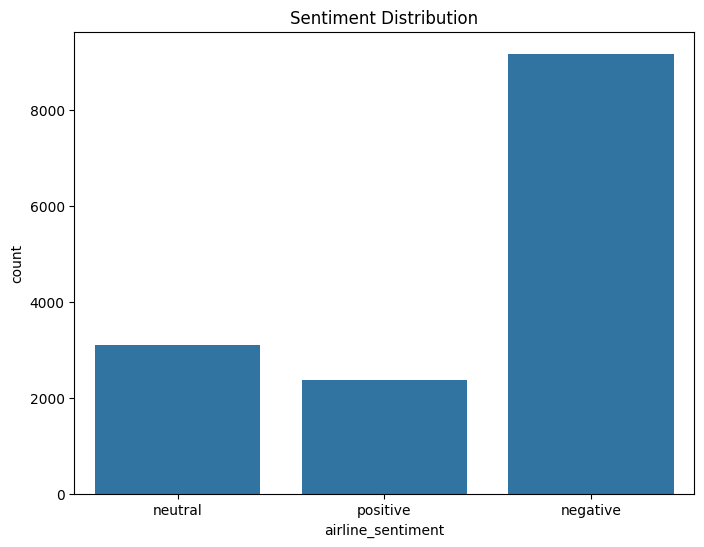

In [7]:
plt.figure(figsize=(8, 6))
sns.countplot(x='airline_sentiment', data=tweets)
plt.title('Sentiment Distribution')
plt.show()

Highly imbalanced. There are many more texts with negative sentiments

### Char/Word Count Analysis

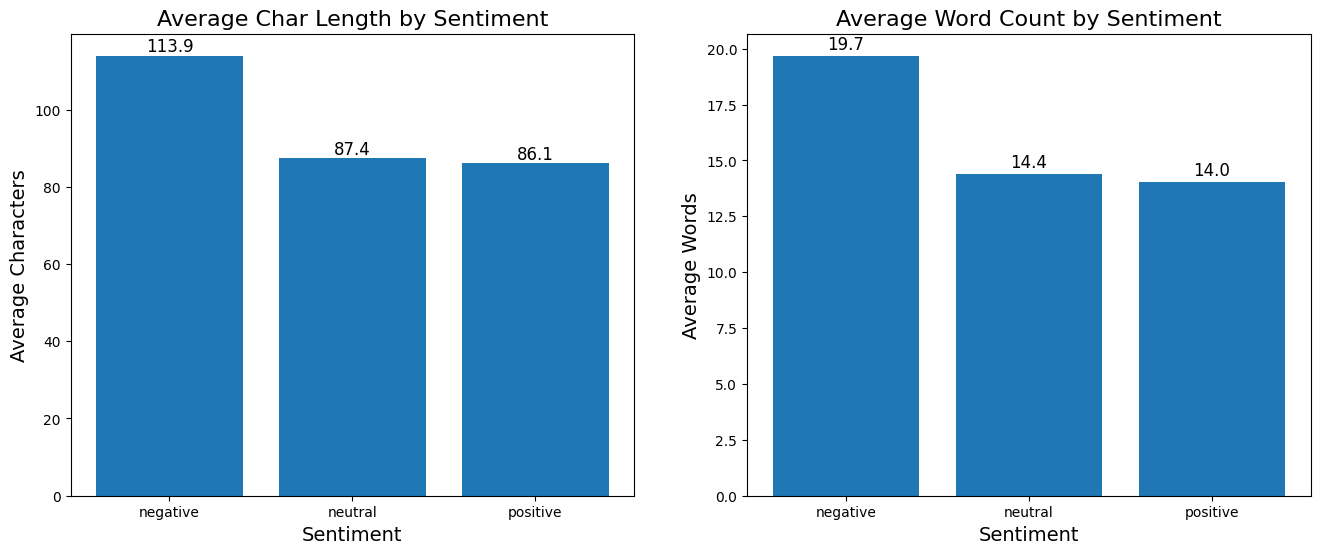

In [10]:
# Add text length features
tweets['char_length'] = tweets['text'].apply(len)
tweets['word_count'] = tweets['text'].apply(lambda x: len(str(x).split()))

# Calculate average lengths by sentiment
avg_lengths = tweets.groupby('airline_sentiment')['char_length'].mean().sort_values(ascending = False)
avg_word_counts = tweets.groupby('airline_sentiment')['word_count'].mean().sort_values(ascending = False)

# Subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

# Plot average text length
ax1.bar(avg_lengths.index, avg_lengths.values)
ax1.set_title('Average Char Length by Sentiment', fontsize=16)
ax1.set_xlabel('Sentiment', fontsize=14)
ax1.set_ylabel('Average Characters', fontsize=14)

for i, value in enumerate(avg_lengths.values):
  ax1.text(i, value + 1, f'{value:.1f}', ha='center', fontsize=12)

# Plot average word count
ax2.bar(avg_word_counts.index, avg_word_counts.values)
ax2.set_title('Average Word Count by Sentiment', fontsize=16)
ax2.set_xlabel('Sentiment', fontsize=14)
ax2.set_ylabel('Average Words', fontsize=14)

for i, value in enumerate(avg_word_counts.values):
  ax2.text(i, value + 0.3, f'{value:.1f}', ha='center', fontsize=12)

plt.show()

Negative tweets are longer than positive or neutral tweets on average

### Common Word Analysis

## Data Cleaning

In [123]:
def at_filter(text):
    return re.sub(r"@\w+", "", text)

def remove_urls(text):
    return re.sub(r'http\S+', '', text)

def remove_amp(text):
    return re.sub(r'&\w+;', '', text)

#Only include alphabets but include ! ?
def alpha_filter(text):
    return re.sub(r'[^a-zA-Z!?# ]', '', text)

def lower_case(text):
    return text.lower()


In [124]:
tweets["text"] = tweets["text"].apply(lambda x: at_filter(x))
tweets["text"] = tweets["text"].apply(lambda x: remove_amp(x))
tweets["text"] = tweets["text"].apply(lambda x: remove_urls(x))
tweets["text"] = tweets["text"].apply(lambda x: alpha_filter(x))
tweets["text"] = tweets["text"].apply(lambda x: lower_case(x))

In [60]:
tweets

,airline_sentiment,sentiment_confidence,text
0,neutral,1.0000,what said
1,positive,0.3486,plus added commercials experience tacky
2,neutral,0.6837,i today must mean i need take another trip!
3,negative,1.0000,really aggressive blast obnoxious entertainmen...
4,negative,1.0000,really big bad thing
...,...,...,...
14634,positive,0.3487,thank got different flight chicago
14635,negative,1.0000,leaving minutes late flight no warnings commu...
14636,neutral,1.0000,please bring american airlines blackberry
14637,negative,1.0000,money change flight answer phones! any suggest...


In [15]:
tweets.to_csv("../content/sample_data/CleanTweets.csv")

## Data transformation

#### Map Tweets into Vectors in R^n

In [80]:
sentence_vectors = tweets["text"].apply(lambda x: bert_encode(x))
data = np.array(list(map(lambda x: x[0], sentence_vectors)))

#### Store Data as a CSV so don't need to re-encode every time

In [82]:
data_frame = pd.DataFrame(data)
data_frame.to_parquet("/content/drive/MyDrive/data/TWITTERBERT_Vectors1.parquet")

In [ ]:
#pq.write_table(table, "../Data/Cleaned/BERT_Vectors.oarquet")

#### BERT Encodings can be found in data below

In [24]:
Bert_Encoded_Text = pd.read_parquet("../content/drive/MyDrive/data/BERT_Vectors.oarquet")
data = Bert_Encoded_Text.to_numpy()

In [25]:
data.shape

(14639, 768)

### K-means using personal implementation

In [83]:
def cos_distance(x1, x2):
    '''
    x1: numpy array, shape = [D]
    x2: numpy array, shape = [D]
    RETURN
        dist: float value
    '''
    #dist = np.sqrt(np.dot(x1-x2,x1-x2))
    x1_length = np.dot(x1, x1)
    x2_length = np.dot(x2, x2)
    cosine = np.dot(x1, x2)/(x1_length*x2_length)
    dist = np.arccos(cosine)/np.arccos(-1)

    ## end
    return dist

In [84]:
def closestCentroid(input_vector, centroid_dict):
    '''
    coordinates_x: numpy array, shape = [D]
    coordinates_centroid: dictionary, key = int, value = numpy array of shape [D]
    RETURN
        closest_centroid: int value
    '''
    closest_centroid = None

    ## start your code here
    smallest_dist = 10**10

    for key in centroid_dict:
        curr_centroid_vector = centroid_dict[key]
        curr_centroid_vector = curr_centroid_vector.reshape(-1)
        curr_dist = cos_distance(curr_centroid_vector, input_vector)

        if (curr_dist < smallest_dist):
            closest_centroid = key
            smallest_dist = curr_dist

    ## end
    return closest_centroid

When using arccos(cosine_similarity)/π as the distance metric, the standard arithmetic mean used in k-means won’t work correctly because it doesn’t preserve unit directionality.

Instead, we need to compute the centroid in a way that maintains the directional nature of the embeddings.

The best approach is to use the normalized mean vector.

In [85]:
def compute_new_centroid(cluster_vectors):
    if len(cluster_vectors) == 0:
        return None  # Handle empty clusters

    cluster_vectors = [vec / np.linalg.norm(vec) for vec in cluster_vectors]

    mean_vector = np.mean(cluster_vectors, axis=0).reshape(-1)  # Step 1: Compute the mean vector
    norm = np.linalg.norm(mean_vector)  # Step 2: Compute its norm

    if norm == 0:
        return np.zeros_like(mean_vector)  # Edge case: if the norm is 0, return a zero vector

    return mean_vector / norm  # Step 3: Normalize to get unit vector

In [86]:
def KMeansClustering(X, initial_centroids, k, n, tolerance=1e-20):
    '''
    X: numpy array, shape = [N, D]
    index_centroids: list, shape = k
    k: int value
    n: int value
    RETURN
        repartition: dictionary, key = int, value = numpy array of shape [number of points in cluster, D]
        coordinates: dictionary, key = int, value = numpy array of shape [D]
    '''


    repartition, centroids,  = None, dict()
    ## start your code here
    # Initialise your first centroids
    for i in range(k):
        centroids[i] = initial_centroids[i]

    # Define stopping criterion
    for i in range(n):
        # Initialise new dictionaries for repartition and coordinates
        repartition = dict()
        for i in range(k):
            repartition[i] = []

        # Assign all the points to the closest cluster centroid
        for vector in X:
            repartition[closestCentroid(vector, centroids)].append(vector)


        # Compute new centroids
        new_centroids = {}
        for cluster_key in repartition:
            new_centroids[cluster_key] = compute_new_centroid(repartition[cluster_key])

        # Check for early stopping (convergence)
        centroid_changes = [np.linalg.norm(new_centroids[cluster_key] - centroids[cluster_key]) for cluster_key in centroids]
        max_change = max(centroid_changes)

        # If the max change in centroids is smaller than the tolerance, stop early
        if max_change < tolerance:
            print(f"Converged early after {i+1} iterations.")
            return repartition, centroids

        # Update centroids for the next iteration
        centroids = new_centroids


    ## end
    return repartition, centroids

### K-Means using sklearn

In [87]:
def sklearnKmeans(X, k, m):
    '''
    X: numpy array, shape = [N, D]
    k: int value
    m: int value
    RETURN
        position: numpy array, shape = [N]
        centers: numpy array, shape = [k, D]
    '''
    position, centers = None, None
    ## start your code here
    kmeans = KMeans(n_clusters=k, init="random", n_init=1, max_iter=m).fit(X)
    position, centers = kmeans.predict(X), kmeans.cluster_centers_
    ## end
    return position, centers

In [88]:
def sklearnKmeans_plus(X, k, m):
    '''
    X: numpy array, shape = [N, D]
    k: int value
    m: int value
    RETURN
        position: numpy array, shape = [N]
        centers: numpy array, shape = [k, D]
    '''
    position, centers = None, None
    ## start your code here
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init=1, max_iter=m).fit(X)
    position, centers = kmeans.predict(X), kmeans.cluster_centers_
    ## end
    return position, centers

## Modelling the Data

In [89]:
def euclideanDist(x1, x2):
    '''
    x1: numpy array, shape = [D]
    x2: numpy array, shape = [D]
    RETURN
        dist: float value
    '''
    dist = np.sqrt(np.dot(x1-x2,x1-x2))
    ## start your code here


    ## end
    return dist

In [90]:
def closest_to_Centroid(clusters, centroids, distance):

    cluster_representatives = dict()
    for cluster in clusters.keys():
        cluster_representatives[cluster] = []

    for cluster in clusters.keys():
        curr_centroid = centroids[cluster]
        smallest_dist = 10**10
        closest_datapoint = clusters[cluster][0]

        for vector in clusters[cluster]:
            curr_dist = distance(vector, curr_centroid)
            if (curr_dist < smallest_dist):
                closest_datapoint = vector
                smallest_dist = curr_dist

        cluster_representatives[cluster] = closest_datapoint

    ## end

    return cluster_representatives

### Initial attempt using SK-Learn Library

In [91]:
position, centers = sklearnKmeans(data, 3, 10000)

In [92]:
clusters = {0:[], 1:[], 2:[]}
N = len(position)

for index in range(N):
    clusters[position[index]].append(data[index])

cluster_representatives = closest_to_Centroid(clusters, centers, euclideanDist)
cluster_rep_indexes = [np.where(data == rep)[0][0] for rep in cluster_representatives.values()]

# labelling the centroids to test accuracy
possible_labels = ["negative", "neutral", "positive"]
possible_clusters = [0, 1, 2]
labels = dict()

for cluster in possible_clusters:
    labels[cluster] = list(tweets["airline_sentiment"][cluster_rep_indexes])[cluster]

predicted_sentiments = list(map(lambda x: labels[x], position))

accuracy = np.mean(tweets["airline_sentiment"] ==  predicted_sentiments)
print(f"accuracy is {np.round(accuracy*100, 2)}%")

accuracy is 61.85%


Accuracy achieved in First attempt is ≈ 39.70%

### Second attempt using SK-Learn Library (K-Means++)

In [93]:
position, centers = sklearnKmeans_plus(data, 3, 10000)

In [94]:
clusters = {0:[], 1:[], 2:[]}
N = len(position)

for index in range(N):
    clusters[position[index]].append(data[index])

cluster_representatives = closest_to_Centroid(clusters, centers, euclideanDist)
cluster_rep_indexes = [np.where(data == rep)[0][0] for rep in cluster_representatives.values()]

# labelling the centroids to test accuracy
possible_labels = ["negative", "neutral", "positive"]
possible_clusters = [0, 1, 2]
labels = dict()

for cluster in possible_clusters:
    labels[cluster] = list(tweets["airline_sentiment"][cluster_rep_indexes])[cluster]

predicted_sentiments = list(map(lambda x: labels[x], position))

accuracy = np.mean(tweets["airline_sentiment"] ==  predicted_sentiments)
print(f"accuracy is {np.round(accuracy*100, 2)}%")

accuracy is 62.7%


Accuracy achieved in Second attempt is ≈ 40.08%

### Third Attempt using own K-Means Clustering algorithm

In [95]:
initial_centroids = [np.array(data[random.randint(0, len(data) - 1)]) for i in range(3)]
clusters2, centers2 = KMeansClustering(data, initial_centroids, 3, 500)

Converged early after 3 iterations.


In [96]:
clusters2 = {0:[], 1:[], 2:[]}
N = len(position)

for index in range(N):
    clusters2[position[index]].append(data[index])

cluster_representatives2 = closest_to_Centroid(clusters2, centers2, cos_distance)
cluster_rep_indexes2 = [np.where(data == rep)[0][0] for rep in cluster_representatives2.values()]

# labelling the centroids to test accuracy
possible_labels = ["negative", "neutral", "positive"]
possible_clusters = [0, 1, 2]
labels2 = dict()

for cluster in possible_clusters:
    labels2[cluster] = list(tweets["airline_sentiment"][cluster_rep_indexes2])[cluster]

predicted_sentiments2 = list(map(lambda x: labels2[x], position))

In [97]:
accuracy2 = np.mean(tweets["airline_sentiment"] ==  predicted_sentiments2)
print(f"accuracy is {np.round(accuracy2*100, 2)}%")

accuracy is 42.52%


Accuracy achieved in Third attempt is ≈ 56.07%

### Fourth Attempt using own K-Means++ Clustering algorithm

In [98]:
def centroid_initalizer(data, k, distance_func):

    n_samples = data.shape[0]
    # Step 1: Choose the first centroid randomly
    first_index = random.randint(0, n_samples - 1)
    centroids = [data[first_index]]

    for _ in range(1, k):
        # Compute the minimum distance to any chosen centroid
        distances = np.array([min(distance_func(x, c) for c in centroids) for x in data])

        # Normalize distances to form a probability distribution
        probabilities = distances / distances.sum()

        # Select next centroid based on weighted probability distribution
        next_index = np.random.choice(n_samples, p=probabilities)
        centroids.append(data[next_index])

    return centroids

In [99]:
initial_centroids = centroid_initalizer(data, 3, cos_distance)
clusters2, centers2 = KMeansClustering(data, initial_centroids, 3, 500)

Converged early after 3 iterations.


In [100]:
clusters2 = {0:[], 1:[], 2:[]}
N = len(position)

for index in range(N):
    clusters2[position[index]].append(data[index])

cluster_representatives2 = closest_to_Centroid(clusters2, centers2, cos_distance)
cluster_rep_indexes2 = [np.where(data == rep)[0][0] for rep in cluster_representatives2.values()]

# labelling the centroids to test accuracy
possible_labels = ["negative", "neutral", "positive"]
possible_clusters = [0, 1, 2]
labels2 = dict()

for cluster in possible_clusters:
    labels2[cluster] = list(tweets["airline_sentiment"][cluster_rep_indexes2])[cluster]

predicted_sentiments2 = list(map(lambda x: labels2[x], position))

In [101]:
accuracy2 = np.mean(tweets["airline_sentiment"] ==  predicted_sentiments2)
print(f"accuracy is {np.round(accuracy2*100, 2)}%")

accuracy is 27.26%


Accuracy achieved in Fourth attempt is ≈ 56.07%

## Fifth Attempt

In [102]:
# 100 Random Seedings
results = dict()

for i in range(100):
    initial_centroids = centroid_initalizer(data, 3, cos_distance)
    clusters2, centers2 = KMeansClustering(data, initial_centroids, 3, 500)

    clusters2 = {0:[], 1:[], 2:[]}
    N = len(position)

    for index in range(N):
        clusters2[position[index]].append(data[index])

    cluster_representatives2 = closest_to_Centroid(clusters2, centers2, cos_distance)
    cluster_rep_indexes2 = [np.where(data == rep)[0][0] for rep in cluster_representatives2.values()]

    # labelling the centroids to test accuracy
    possible_labels = ["negative", "neutral", "positive"]
    possible_clusters = [0, 1, 2]
    labels2 = dict()

    for cluster in possible_clusters:
        labels2[cluster] = list(tweets["airline_sentiment"][cluster_rep_indexes2])[cluster]

    predicted_sentiments2 = list(map(lambda x: labels2[x], position))

    accuracy2 = np.mean(tweets["airline_sentiment"] ==  predicted_sentiments2)
    results[i] = (accuracy2, (clusters2, centers2))

Converged early after 3 iterations.
Converged early after 3 iterations.
Converged early after 3 iterations.
Converged early after 3 iterations.
Converged early after 3 iterations.
Converged early after 3 iterations.
Converged early after 3 iterations.
Converged early after 3 iterations.
Converged early after 3 iterations.
Converged early after 3 iterations.
Converged early after 3 iterations.
Converged early after 3 iterations.
Converged early after 3 iterations.
Converged early after 3 iterations.
Converged early after 3 iterations.
Converged early after 3 iterations.
Converged early after 3 iterations.
Converged early after 3 iterations.
Converged early after 3 iterations.
Converged early after 3 iterations.
Converged early after 3 iterations.
Converged early after 3 iterations.
Converged early after 3 iterations.
Converged early after 3 iterations.
Converged early after 3 iterations.
Converged early after 3 iterations.
Converged early after 3 iterations.
Converged early after 3 iter

### Think of new ways to improve

#### PCA Analysis

In [103]:
scaler = StandardScaler()
bert_vectors_std = scaler.fit_transform(Bert_Encoded_Text)  # Shape: (N, 768)

# Choose the number of components
n_components = 50 # Example: Reduce to 50 dimensions
pca = PCA(n_components=n_components)

bert_pca = pca.fit_transform(bert_vectors_std)  # Shape: (N, 50)

In [104]:
initial_centroids = centroid_initalizer(bert_pca, 3, cos_distance)
clusters2, centers2 = KMeansClustering(bert_pca, initial_centroids, 3, 500)

Converged early after 3 iterations.


In [105]:
clusters2 = {0:[], 1:[], 2:[]}
N = len(position)

for index in range(N):
    clusters2[position[index]].append(bert_pca[index])

cluster_representatives2 = closest_to_Centroid(clusters2, centers2, cos_distance)
cluster_rep_indexes2 = [np.where(bert_pca == rep)[0][0] for rep in cluster_representatives2.values()]

# labelling the centroids to test accuracy
possible_labels = ["negative", "neutral", "positive"]
possible_clusters = [0, 1, 2]
labels2 = dict()

for cluster in possible_clusters:
    labels2[cluster] = list(tweets["airline_sentiment"][cluster_rep_indexes2])[cluster]

predicted_sentiments2 = list(map(lambda x: labels2[x], position))

In [106]:
accuracy2 = np.mean(tweets["airline_sentiment"] ==  predicted_sentiments2)
print(f"accuracy is {np.round(accuracy2*100, 2)}%")

accuracy is 54.49%


Accuracy achieved in Sixth attempt is ≈ 35.64%

## PCA Might Not Be the Best Approach
#### PCA finds linear patterns, but BERT vectors often have nonlinear structure.

#### UMAP (Uniform Manifold Approximation and Projection)

In [107]:
import umap.umap_ as um

In [108]:
umap = um.UMAP(n_components=50, random_state=42)
bert_umap = umap.fit_transform(Bert_Encoded_Text)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [110]:
initial_centroids = centroid_initalizer(bert_umap, 3, cos_distance)
clusters2, centers2 = KMeansClustering(bert_umap, initial_centroids, 3, 500)

TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

In [ ]:
clusters2 = {0:[], 1:[], 2:[]}
N = len(position)

for index in range(N):
    clusters2[position[index]].append(bert_umap[index])

cluster_representatives2 = closest_to_Centroid(clusters2, centers2, cos_distance)
cluster_rep_indexes2 = [np.where(bert_umap == rep)[0][0] for rep in cluster_representatives2.values()]

# labelling the centroids to test accuracy
possible_labels = ["negative", "neutral", "positive"]
possible_clusters = [0, 1, 2]
labels2 = dict()

for cluster in possible_clusters:
    labels2[cluster] = list(tweets["airline_sentiment"][cluster_rep_indexes2])[cluster]

predicted_sentiments2 = list(map(lambda x: labels2[x], position))

In [ ]:
accuracy2 = np.mean(tweets["airline_sentiment"] ==  predicted_sentiments2)
print(f"accuracy is {np.round(accuracy2*100, 2)}%")

Accuracy achieved in Seventh attempt is ≈ 54.55%

### It seems like BERT Encoding with Cosine-distance K-Means++ still outperforms it